# Rebuilding Fastai's 3 or 7 Digit Classifier

### Setup and data preparation

In [1]:
# !pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
# Getting sample data from the MNIST dataset

path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# Setting the base path to simplify path structures

Path.BASE_PATH = path

In [4]:
# Inspecting contents of path as a list
# Structure includes training and label data, as well as a predefined validation dataset

path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [5]:
# Further inspection shows that the train dataset has a folder of 3s and a folder of 7s

(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
# Assign the folder contents to variables as lists and sort them

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [133]:
# Checking one
# The Image class used is from pythons Imaging Library (PIL)

im3_path = threes[3]
im3 = Image.open(im3_path)
im3

In [8]:
# We can view the image numerically as an array

array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# Or as a tensor

tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
#checking an example as a dataframe

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [13]:
# and as a shaded dataframe

df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [16]:
# creating lists of the images in the 7 and 3 folders

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [17]:
# using torch.stack to stack the tensors into a 3 dimensional tensor

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

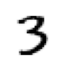

In [19]:
# showing a value from the stacked tensor of 3s

a_3 = stacked_threes[1]
show_image(a_3);

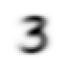

In [21]:
# the average 3

mean3 = stacked_threes.mean(0)
show_image(mean3);

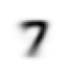

In [22]:
# the average 7

mean7 = stacked_sevens.mean(0)
show_image(mean7);

In [23]:
# creating stacked tensors for the validations sets

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [25]:
# creating a simple distance function and using it to measure the distance between a single 3 and the average of all 3s

def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [26]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138]),
 torch.Size([1010]))

#### Preparing the data

Stacked_threes and stacked_sevens are tensors with three dimensions

When stacked they have size 12396 x 28 x 28

Torch.cat stacks them, and the view method unwraps them into a 12396 x 784 2 dimensional tensor

In [46]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

zip and list combine to create a dataset that returns an (x,y) tuple

In [44]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [49]:
# Do the same for the validation data

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

A function to initialise the parameters, with gradients

In [51]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

Initialising the weights and including a bias coefficient

In [67]:
# This is a vector of length 28^2

weights = init_params((28*28,1))

In [68]:
bias = init_params(1)

In [69]:
# Trying this out on a single picture from the training dataset

(train_x[0]*weights.T).sum() + bias

tensor([14.0882], grad_fn=<AddBackward0>)

This multiplies every image by the weights, and adds a bias

The output is a vector with the sum product of each image by the weights, plus the bias

In [70]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[14.0882],
        [13.9915],
        [16.0442],
        ...,
        [ 1.2085],
        [ 1.7146],
        [ 2.6879]], grad_fn=<AddBackward0>)

This step uses boolean logic to say that if the score > 0.5 then it's a 3, otherwise it's a 7

In [71]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [72]:
# Calculating the accuracy rate

corrects.float().mean().item()

0.5766376256942749

Adjusting the weights slightly and creating a new prediction gives a slightly different accuracy

In [79]:
weights[0] *= 1.0001

In [80]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5642949342727661

The sigmoid function allows for a continuous, smooth loss function even when the classification accuracy is not affected by a change in parameters

In [81]:
def sigmoid(x): return 1/(1+torch.exp(-x))

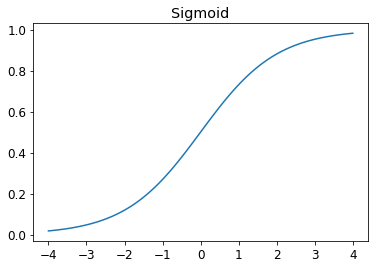

In [77]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

The Loss function then provides loss values for a set of predictions that will change for any change in weights

In [78]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### Putting it together

In [98]:
# Reinitialise Paramters

weights = init_params((28*28,1))
bias = init_params(1)

In [99]:
# Use fastai's dataloader to load the dataset

dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [100]:
# And validation dataset

valid_dl = DataLoader(valid_dset, batch_size=256)

In [101]:
# This function:
#     Takes the input data
#     Makes predictions based on the model ax + b
#     Calculates the loss using the sigmoid functionality when comparing to the dependent values
#     Calculated the gradients using the .backward() method

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [103]:
# Testing it with a few datapoints

batch = train_x[:4]

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0017), tensor([-0.0118]))

The next step takes the data, the learning rate, and the parameters as inputs

It calculated gradients and adjusts the parameters by the gradients x learning rates

It resets the gradients to zero, since PyTorch retains gradients and will add to them otherwise

In [104]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

A function to check the batch accuracy feeds the data through the sigmoid function and then categorises it

In [107]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [108]:
# Checking if it works

batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

A wider validation function checks the model's predictions against the labels for every image and returns the average accuracy rate

In [109]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [110]:
validate_epoch(linear1)

0.6883

Training for a single epoch...

In [111]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7177

And training for 20 more gives steadily increasing accuracy

In [112]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8837 0.9398 0.9549 0.9593 0.9613 0.9652 0.9666 0.9681 0.9676 0.9676 0.9681 0.9681 0.9686 0.9686 0.9691 0.9695 0.9695 0.97 0.971 0.971 

### Using PyTorch to make implementation easier

nn.Linear does the same thing as our init_params and linear together. It contains both the weights and biases in a single class.

In [113]:
linear_model = nn.Linear(28*28,1)

Simple Optimizer:

In [114]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
            
opt = BasicOptim(linear_model.parameters(), lr)

In [115]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [116]:
validate_epoch(linear_model)

0.4639

In [117]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [118]:
train_model(linear_model, 20)

0.4932 0.7768 0.8554 0.917 0.9365 0.9496 0.9565 0.9633 0.9657 0.9677 0.9696 0.9716 0.9736 0.9745 0.976 0.9765 0.9775 0.978 0.978 0.9789 

Fastai provides the SGD class which does the same thing as the BasicOptim

In [119]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7754 0.8623 0.9179 0.9355 0.9487 0.9579 0.9638 0.9657 0.9672 0.9692 0.9726 0.9741 0.9745 0.9755 0.977 0.9775 0.9775 0.978 0.9785 

It also provides Learner.fit which can be used instead of train_model

In [120]:
dls = DataLoaders(dl, valid_dl)

In [121]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [122]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.635865,0.502849,0.495584,00:00
1,0.379722,0.259478,0.761040,00:00
2,0.144540,0.158572,0.858685,00:00
3,0.066544,0.099434,0.917566,00:00
4,0.037609,0.074198,0.934740,00:00
5,0.026163,0.060126,0.949951,00:00
6,0.021359,0.051220,0.956820,00:00
7,0.019145,0.045230,0.964181,00:00
8,0.017964,0.040989,0.966143,00:00
9,0.017219,0.037848,0.968106,00:00


### Adding a Nonlinearity

In [123]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

w1 has 30 output activations, so w2 must have 30 matching input activations

In [124]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The nonlinearity is just the relu function. Relu means rectified linear unit.

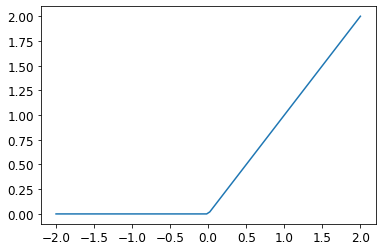

In [125]:
plot_function(F.relu)

Again, this can be replaced with ready-made components from PyTorch

In [126]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [127]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [128]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.298954,0.410011,0.505888,00:00
1,0.141931,0.219284,0.819431,00:00
2,0.079610,0.112800,0.915604,00:00
3,0.052965,0.077275,0.940137,00:00
4,0.040481,0.060771,0.955839,00:00
5,0.034022,0.051403,0.963690,00:00
6,0.030262,0.045472,0.965162,00:00
7,0.027794,0.041397,0.966143,00:00
8,0.026003,0.038421,0.968106,00:00
9,0.024613,0.036136,0.969578,00:00


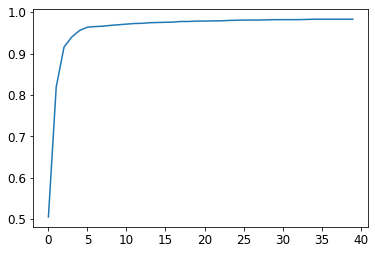

In [129]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [130]:
learn.recorder.values[-1][2]

0.982826292514801

Finally, showing the power of deeper, more fine tuned models: an 18 layer neural network does a better job with just a single epoch

In [131]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.104944,0.018076,0.997056,00:22
